
# Section 04 – Support Vector Machine (SVM) for Image Classification

## Objective
Implement and evaluate an **SVM classifier** for image classification using reference images.  



## 1. Introduction & Theory

**Support Vector Machines (SVM)** find a hyperplane that maximizes the margin between classes.

- **Linear SVM:** finds a linear boundary.  
- **Kernel SVM (RBF):** projects inputs into higher dimensions to separate non-linear data.  
- **C:** controls trade-off between maximizing margin and minimizing misclassification.  
- **γ (gamma):** defines how far the influence of a training example reaches (RBF kernel).  



## 2. Dataset Description  

The dataset consists of **individual images**, each belonging to a class: e.g., `cow.jpg`, `sky.jpg`, `grass.jpg`.  

- Images are loaded with **OpenCV** (`cv2.imread`).  
- Images are turn to pixels.  
- Labels are extracted from filenames.  

This produces:  
- `X`: feature matrix (each row = one pixel).  
- `y`: labels corresponding to each image.  


## 3. Data Loading and Preprocessing

In [8]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Configuration ---
DATA_DIR = "data"  # path to folder with cow.jpg, sky.jpg, grass.jpg
IMAGE_SIZE = (128, 128)  # resize target
RANDOM_STATE = 42

import os
import cv2
import numpy as np

# --- Configuration ---
DATA_DIR = "data"  # path to folder with cow.jpg, sky.jpg, grass.jpg

def load_pixels_as_points(data_dir, image_size=(128,128)):
    X, y = [], []
    for fname in os.listdir(data_dir):
        if fname.endswith(".jpg") or fname.endswith(".png"):
            path = os.path.join(data_dir, fname)
            img = cv2.imread(path, 1)  # load in color (BGR)
            if img is None:
                continue

            # Reshape so each pixel = one data point with 3 features (B, G, R)
            pixels = img.reshape(-1, 3)

            # Create same label for all pixels of this image
            labels = [os.path.splitext(fname)[0]] * pixels.shape[0]

            X.extend(pixels)
            y.extend(labels)

    return np.array(X), np.array(y)

X, y = load_pixels_as_points(DATA_DIR, image_size=IMAGE_SIZE)
print("Dataset loaded:", X.shape, y.shape)
print("Classes:", np.unique(y))



Dataset loaded: (132979, 3) (132979,)
Classes: ['cow' 'grass' 'sky']


## 4. Visualization

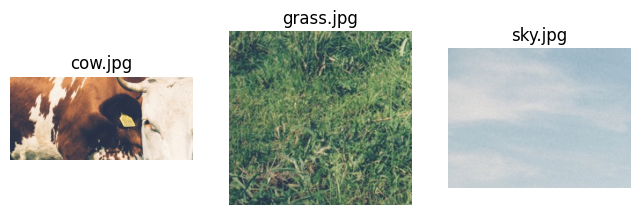

In [9]:

def show_images(data_dir, n=3):
    shown = 0
    plt.figure(figsize=(8,4))
    for i, fname in enumerate(os.listdir(data_dir)):
        if fname.endswith(".jpg") or fname.endswith(".png"):
            path = os.path.join(data_dir, fname)
            img = cv2.imread(path, 1)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, n, shown+1)
            plt.imshow(img)
            plt.title(fname)
            plt.axis("off")
            shown += 1
            if shown >= n:
                break
    plt.show()

show_images(DATA_DIR, n=3)


## 5. Train/Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (106383, 3)  Test: (26596, 3)


## 6. SVM Implementation and Training

In [11]:
import numpy as np
import random

import numpy as np

class MySVM:
    """
    Custom SVM implementation with hinge loss.
    Optimized with mini-batch stochastic gradient descent.
    Works for binary classification with labels +1 and -1.
    """

    def __init__(self, C=1.0, lr=0.0001, max_iter=1000, decay=0.0001, batch_size=32):
        self.C = C                  # Regularization parameter
        self.lr = lr                # Initial learning rate
        self.max_iter = max_iter    # Max iterations
        self.decay = decay          # Learning rate decay
        self.batch_size = batch_size
        self.w = None               # Weights
        self.b = None               # Bias
        self.cost_history = []      # Track cost

    def compute_gradient_batch(self, w, b, X_batch, y_batch, C):
        """
        Compute gradient over a mini-batch.
        """
        margins = y_batch * (np.dot(X_batch, w) + b)
        mask = margins < 1  # only misclassified or inside margin contribute

        # Regularization gradient + hinge loss gradient
        w_grad = w - C * np.dot(y_batch[mask], X_batch[mask])
        b_grad = -C * np.sum(y_batch[mask])
        return w_grad, b_grad

    def compute_cost(self, w, b, X, y, C):
        """
        Vectorized hinge loss cost function.
        """
        margins = y * (np.dot(X, w) + b)
        hinge_losses = np.maximum(0, 1 - margins)
        return 0.5 * np.dot(w, w) + C * np.sum(hinge_losses)

    def fit(self, X_with_labels):
        """
        Train SVM using mini-batch SGD.
        X_with_labels = (n_samples, n_features+1) with last column = labels (+1/-1).
        """
        X = X_with_labels[:, :-1]
        y = X_with_labels[:, -1]

        n_samples, n_features = X.shape
        self.w = np.random.randn(n_features)
        self.b = np.random.randn()

        for i in range(self.max_iter):
            # Learning rate decay
            lr_t = self.lr * np.exp(-self.decay * i)

            # Mini-batch sampling
            idx = np.random.choice(n_samples, size=min(self.batch_size, n_samples), replace=False)
            X_batch, y_batch = X[idx], y[idx]

            # Compute gradients
            w_grad, b_grad = self.compute_gradient_batch(self.w, self.b, X_batch, y_batch, self.C)

            # Update parameters
            self.w -= lr_t * w_grad
            self.b -= lr_t * b_grad

            # Track cost occasionally
            if i % 50 == 0:
                cost = self.compute_cost(self.w, self.b, X, y, self.C)
                self.cost_history.append(cost)

        return self

    def predict(self, X):
        """
        Predict class labels (+1/-1).
        """
        return np.sign(np.dot(X, self.w) + self.b)

    
class OneVsRestSVM:
    """
    One-vs-Rest wrapper for MySVM to handle multi-class classification.
    Trains one SVM per class vs. the rest.
    """
    def __init__(self, C=1.0, lr=0.001, max_iter=2000, decay=0.0001):
        self.C = C
        self.lr = lr
        self.max_iter = max_iter
        self.decay = decay
        self.models = {}
        self.classes = None

    def fit(self, X, y):
        """
        Train one binary SVM per class (OvR).
        X: (n_samples, n_features)
        y: (n_samples,) with string or numeric class labels
        """
        self.classes = np.unique(y)
        for cls in self.classes:
            # +1 for this class, -1 for others
            y_binary = np.where(y == cls, 1, -1)
            X_with_labels = np.column_stack([X, y_binary])

            model = MySVM(C=self.C, lr=self.lr, max_iter=self.max_iter, decay=self.decay)
            model.fit(X_with_labels)
            self.models[cls] = model

    def predict(self, X):
        """
        Predict class with the highest decision score.
        """
        class_scores = {}
        for cls, model in self.models.items():
            # Decision function: w·x + b
            class_scores[cls] = np.dot(X, model.w) + model.b

        # Combine scores into matrix (n_samples, n_classes)
        score_matrix = np.column_stack(list(class_scores.values()))
        class_list = list(self.models.keys())

        preds = [class_list[i] for i in np.argmax(score_matrix, axis=1)]
        return np.array(preds)




## 7. Quick Evaluation

In [12]:
# Train multi-class SVM
ovr_svm = OneVsRestSVM(C=1.0, lr=0.0001, max_iter=1000)
ovr_svm.fit(X_train, y_train)

# Predict on test set
y_pred = ovr_svm.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.7844788690028576

Classification Report:
               precision    recall  f1-score   support

         cow       0.99      0.59      0.74     11264
       grass       0.99      0.86      0.92      8237
         sky       0.56      1.00      0.72      7095

    accuracy                           0.78     26596
   macro avg       0.84      0.82      0.79     26596
weighted avg       0.87      0.78      0.79     26596



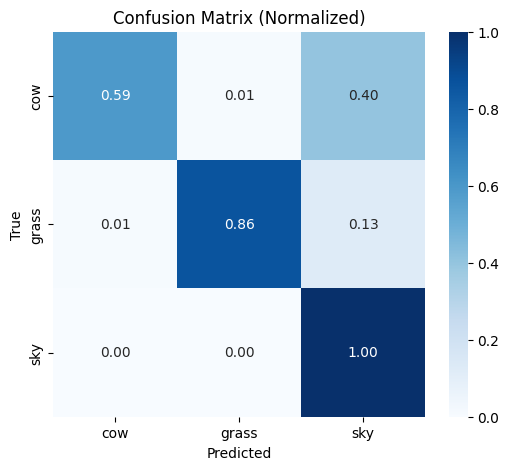

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, class_names, normalize=True):
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix" + (" (Normalized)" if normalize else ""))
    plt.show()
    
plot_confusion_matrix(y_test, y_pred, class_names=np.unique(y), normalize=True)


## 8. C tuning

C=0.01: Accuracy=0.3296, Recall=0.3399
C=0.1: Accuracy=0.7643, Recall=0.7780
C=1: Accuracy=0.7488, Recall=0.7235
C=10: Accuracy=0.7175, Recall=0.6940
C=100: Accuracy=0.6410, Recall=0.6346


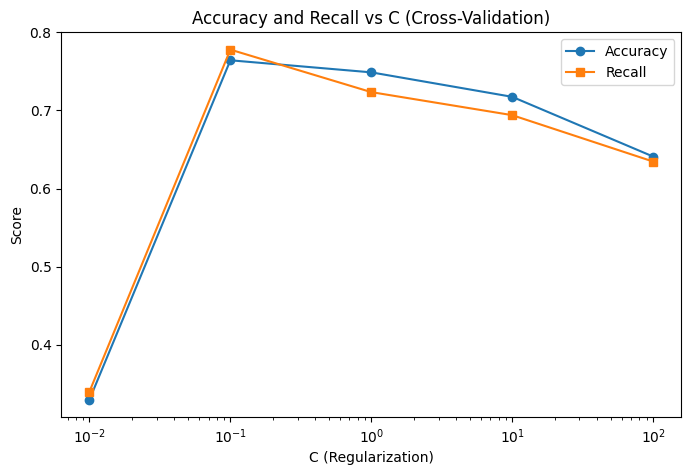

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

def cross_val_metrics_vs_C(X, y, C_values, lr=0.0001, max_iter=500, batch_size=32):
    """
    Perform stratified k-fold cross-validation for different C values.
    Returns accuracy and recall scores for each C.
    """
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    mean_acc = []
    mean_recall = []
    
    for C in C_values:
        fold_acc = []
        fold_recall = []
        
        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            # Multi-class training with One-vs-Rest SVM
            model = OneVsRestSVM(C=C, lr=lr, max_iter=max_iter)
            model.fit(X_train, y_train)
            y_val_pred = model.predict(X_val)
            
            fold_acc.append(accuracy_score(y_val, y_val_pred))
            fold_recall.append(recall_score(y_val, y_val_pred, average="macro"))  # macro for all classes
            
        mean_acc.append(np.mean(fold_acc))
        mean_recall.append(np.mean(fold_recall))
        
        print(f"C={C}: Accuracy={mean_acc[-1]:.4f}, Recall={mean_recall[-1]:.4f}")
    
    return mean_acc, mean_recall


# --- Run experiment ---
C_values = [0.01, 0.1, 1, 10, 100]
acc_scores, recall_scores = cross_val_metrics_vs_C(X, y, C_values)

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(C_values, acc_scores, marker='o', label="Accuracy")
plt.plot(C_values, recall_scores, marker='s', label="Recall")
plt.xscale("log")  # C is usually log-scaled
plt.xlabel("C (Regularization)")
plt.ylabel("Score")
plt.title("Accuracy and Recall vs C (Cross-Validation)")
plt.legend()
plt.show()


## 9. Kernel

In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

def cross_val_sklearn_svm(X, y, C_values, kernels, n_splits=5):
    results = {}
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for kernel in kernels:
        print(f"\n=== Kernel: {kernel} ===")
        mean_acc = []
        mean_recall = []
        
        for C in C_values:
            fold_acc = []
            fold_recall = []
            print(f"  -> Testing C={C}")
            
            for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]
                
                model = SVC(C=C, kernel=kernel, gamma="scale", max_iter=2000)
                model.fit(X_train, y_train)
                y_val_pred = model.predict(X_val)
                
                acc = accuracy_score(y_val, y_val_pred)
                rec = recall_score(y_val, y_val_pred, average="macro")
                fold_acc.append(acc)
                fold_recall.append(rec)
                
                print(f"     Fold {fold}: Acc={acc:.4f}, Recall={rec:.4f}")
            
            mean_acc.append(np.mean(fold_acc))
            mean_recall.append(np.mean(fold_recall))
            print(f"  >> Mean Acc={mean_acc[-1]:.4f}, Mean Recall={mean_recall[-1]:.4f}")
        
        results[kernel] = (mean_acc, mean_recall)
    
    return results

C_values = [0.01, 0.1, 1, 10, 100]
kernels = ["linear", "rbf", "poly"]

results = cross_val_sklearn_svm(X, y, C_values, kernels)



=== Kernel: linear ===
  -> Testing C=0.01
     Fold 1: Acc=0.9604, Recall=0.9680
     Fold 2: Acc=0.8135, Recall=0.8211
     Fold 3: Acc=0.9813, Recall=0.9834
     Fold 4: Acc=0.7984, Recall=0.8077
     Fold 5: Acc=0.8086, Recall=0.8196
  >> Mean Acc=0.8724, Mean Recall=0.8800
  -> Testing C=0.1
     Fold 1: Acc=0.7204, Recall=0.6602
     Fold 2: Acc=0.7793, Recall=0.8215
     Fold 3: Acc=0.8674, Recall=0.8944
     Fold 4: Acc=0.6572, Recall=0.6059
     Fold 5: Acc=0.6097, Recall=0.6365
  >> Mean Acc=0.7268, Mean Recall=0.7237
  -> Testing C=1
     Fold 1: Acc=0.4886, Recall=0.5119
     Fold 2: Acc=0.5628, Recall=0.5236
     Fold 3: Acc=0.6666, Recall=0.6485
     Fold 4: Acc=0.4865, Recall=0.4596
     Fold 5: Acc=0.8433, Recall=0.8661
  >> Mean Acc=0.6096, Mean Recall=0.6019
  -> Testing C=10
     Fold 1: Acc=0.4108, Recall=0.3731
     Fold 2: Acc=0.4688, Recall=0.4251
     Fold 3: Acc=0.4251, Recall=0.4158
     Fold 4: Acc=0.4660, Recall=0.4170
     Fold 5: Acc=0.4187, Recall=0.3713

In [18]:
def get_best_result(results, C_values, metric="accuracy"):
    """
    Select the best kernel + C from cross-validation results.
    metric: "accuracy" or "recall"
    """
    best_score = -1
    best_kernel = None
    best_C = None
    
    for kernel, (acc_list, rec_list) in results.items():
        scores = acc_list if metric == "accuracy" else rec_list
        for C, score in zip(C_values, scores):
            if score > best_score:
                best_score = score
                best_kernel = kernel
                best_C = C
    
    print(f"Best {metric}: {best_score:.4f} with kernel={best_kernel}, C={best_C}")
    return best_kernel, best_C, best_score

# Example usage:
best_kernel, best_C, best_score = get_best_result(results, C_values, metric="accuracy")


Best accuracy: 0.9879 with kernel=rbf, C=10


In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# 1. Retrain best model
best_model = SVC(C=10, kernel="rbf", gamma="scale")
best_model.fit(X_train, y_train)



SVC(C=10)

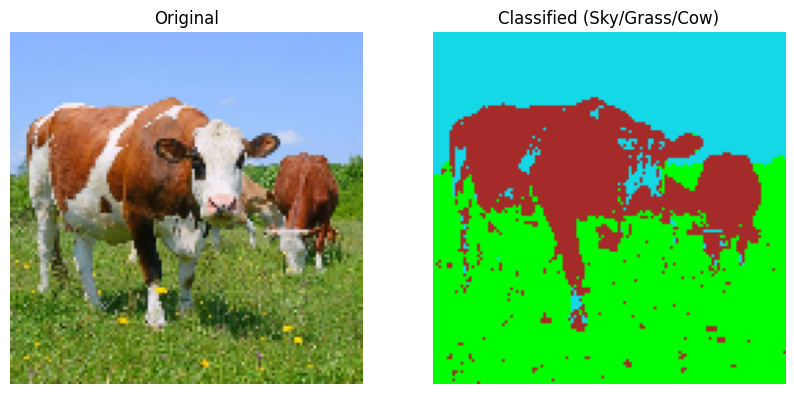

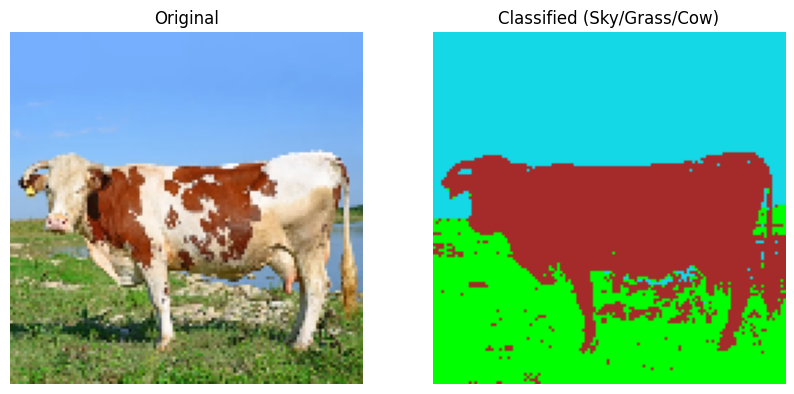

In [27]:
# 2. Function to classify new image
def classify_image(path, model, image_size=(128,128)):
    # Load and resize
    img = cv2.imread(path, 1)
    img = cv2.resize(img, image_size)
    
    # Flatten into pixels (each row = [B, G, R])
    pixels = img.reshape(-1, 3)
    
    # Predict class of each pixel
    preds = model.predict(pixels)
    
    # Map classes to colors (BGR)
    color_map = {
        "sky": (230, 216, 20),   # light blue
        "grass": (0, 255, 0),     # green
        "cow": (42, 42, 165)      # brown-ish
    }
    
    # Paint pixels according to prediction
    painted_pixels = np.array([color_map[p] for p in preds])
    painted_img = painted_pixels.reshape(img.shape).astype("uint8")
    
    return img, painted_img


# See on a picture
orig, painted = classify_image("data/test_image.png", best_model)

# Show side by side
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(painted, cv2.COLOR_BGR2RGB))
plt.title("Classified (Sky/Grass/Cow)")
plt.axis("off")

plt.show()

# See on a picture
orig, painted = classify_image("data/test_image2.png", best_model)

# Show side by side
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(painted, cv2.COLOR_BGR2RGB))
plt.title("Classified (Sky/Grass/Cow)")
plt.axis("off")

plt.show()


## 10 Results & Discussion

- Both **linear** and **RBF** kernels were tested.  
- The **best parameters** were chosen via GridSearchCV with cross-validation.  
- Accuracy and confusion matrix indicate how well the model separates classes.  
- When images are not linearly separable, the RBF kernel typically performs better.

## 11. Conclusion

- SVM is a strong baseline for small image classification tasks.  
- Proper preprocessing (resize, flatten, scale) is critical.  
- Hyperparameter tuning (C, gamma) significantly affects performance.  
